Please upload your Walmart Sales Forecast dataset CSV file (e.g., 'Walmart.csv').


Saving train.csv to train.csv

Dataset loaded successfully!
Shape: (421570, 5)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Linear Regression Performance:
MAE  : 15189.66
RMSE : 21948.45
R²   : -0.000

XGBoost Regressor Performance:
MAE  : 15257.78
RMSE : 21976.45
R²   : -0.003


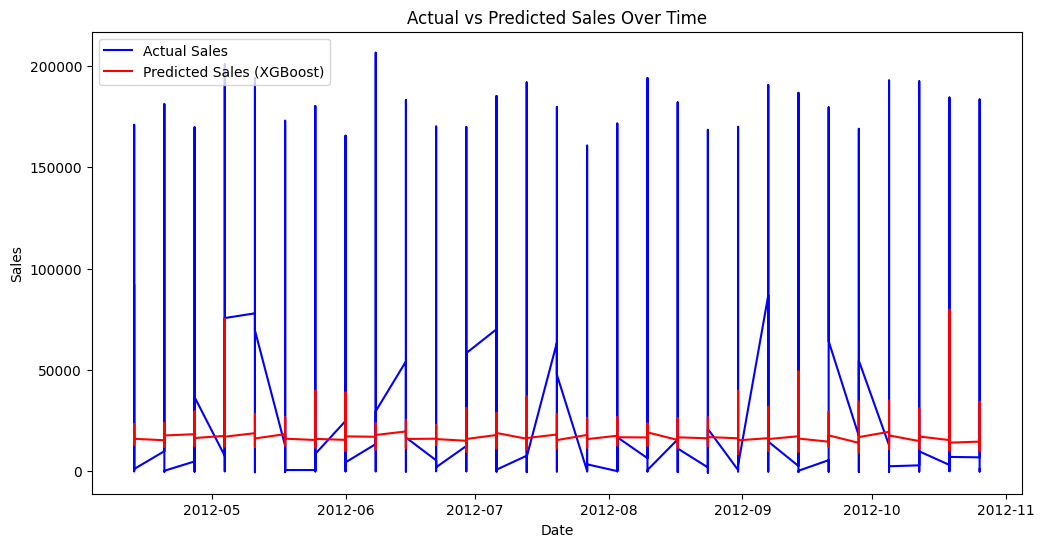


Forecasting complete.


In [1]:
# ============================================================
# Task 7: Sales Forecasting (Walmart Sales Forecast)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from google.colab import files

# ============================================================
# Step 1: Upload Dataset
# ============================================================

print("Please upload your Walmart Sales Forecast dataset CSV file (e.g., 'Walmart.csv').")
uploaded = files.upload()

for fn in uploaded.keys():
    df = pd.read_csv(fn)

print("\nDataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head())

# ============================================================
# Step 2: Basic Cleaning
# ============================================================

# Try to detect the date column
date_col = None
for col in df.columns:
    if 'date' in col.lower():
        date_col = col
        break

if date_col is None:
    raise ValueError("No date column found! Please ensure your dataset has a column with 'date' in its name.")

df[date_col] = pd.to_datetime(df[date_col])

# Detect target (sales) column
target_col = None
for col in df.columns:
    if 'sales' in col.lower():
        target_col = col
        break

if target_col is None:
    raise ValueError("No sales column found! Please ensure your dataset has a column with 'sales' in its name.")

# Sort by date
df = df.sort_values(by=date_col)

# ============================================================
# Step 3: Feature Engineering
# ============================================================

df['year'] = df[date_col].dt.year
df['month'] = df[date_col].dt.month
df['day'] = df[date_col].dt.day
df['dayofweek'] = df[date_col].dt.dayofweek

# Lag and rolling average features
df['sales_lag_1'] = df[target_col].shift(1)
df['sales_lag_7'] = df[target_col].shift(7)
df['rolling_mean_7'] = df[target_col].shift(1).rolling(window=7).mean()

# Drop missing values due to lags
df = df.dropna()

# ============================================================
# Step 4: Train/Test Split (Time-aware)
# ============================================================

X = df[['year', 'month', 'day', 'dayofweek', 'sales_lag_1', 'sales_lag_7', 'rolling_mean_7']]
y = df[target_col]

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ============================================================
# Step 5: Model Training
# ============================================================

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# XGBoost Regression
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ============================================================
# Step 6: Evaluation
# ============================================================

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.3f}")

evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("XGBoost Regressor", y_test, xgb_pred)

# ============================================================
# Step 7: Visualization
# ============================================================

plt.figure(figsize=(12, 6))
plt.plot(df[date_col].iloc[split_idx:], y_test.values, label='Actual Sales', color='blue')
plt.plot(df[date_col].iloc[split_idx:], xgb_pred, label='Predicted Sales (XGBoost)', color='red')
plt.title("Actual vs Predicted Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

print("\nForecasting complete.")
